In [1]:
from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
import acoustic_entrainment
import utils
reload(brownian)
reload(time_series)
reload(acoustic_entrainment)
reload(utils)
from acoustic_entrainment import VelocityResponse, muflown_response, muflown_sensitivity, mic_response
from time_series import find_files, find_ders, CollectionTDMS, bin_func, TimeSeries
from brownian import System, abc_guess, get_krhoA, psd_func, logbin_func, get_sound_speed, psd_abc_func
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import numpy as np

from os import path

from matplotlib import rc
fontsize = 10
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
    "text.latex.preamble":r'\usepackage{upgreek}' 
}

plt.rcParams.update(fontstyle)
letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"] 
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()] 
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):     
    letters = letters_map[mode]     
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,             
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)


In [2]:
from utils import *

# Directory structure

In [3]:
# Data by date
base_der = "/data/brownian"

date_ders = sorted(find_ders(base_der))
date_ders

['/data/brownian/20211215',
 '/data/brownian/20220330',
 '/data/brownian/20220518',
 '/data/brownian/20220523',
 '/data/brownian/20220525',
 '/data/brownian/20220614',
 '/data/brownian/20220628',
 '/data/brownian/20220707',
 '/data/brownian/20220715',
 '/data/brownian/20220720',
 '/data/brownian/20220722',
 '/data/brownian/20220726',
 '/data/brownian/20221019',
 '/data/brownian/20230216',
 '/data/brownian/20230220',
 '/data/brownian/20230404',
 '/data/brownian/20230501']

In [4]:
# Select a date
date_der_index = 16
bead_ders = find_ders(date_ders[date_der_index])
bead_ders

['/data/brownian/20230501/bead1']

In [5]:
# Select a date
bead_der_index = 0
experiment_ders = sorted(find_ders(bead_ders[bead_der_index]))
experiment_ders

['/data/brownian/20230501/bead1/ac-dc_nobead_pulse2',
 '/data/brownian/20230501/bead1/ac-dc_pulse',
 '/data/brownian/20230501/bead1/ac-dc_pulse2',
 '/data/brownian/20230501/bead1/ac-dc_pulse3',
 '/data/brownian/20230501/bead1/ac-ph_40kHz-10burst',
 '/data/brownian/20230501/bead1/ac-ph_4kHz-10burst',
 '/data/brownian/20230501/bead1/ac-ph_ene-15-19-5_pos0-10-11',
 '/data/brownian/20230501/bead1/bright_noise',
 '/data/brownian/20230501/bead1/dc-ac_baseline_1',
 '/data/brownian/20230501/bead1/dc-ac_baseline_2',
 '/data/brownian/20230501/bead1/dc-ac_baseline_3',
 '/data/brownian/20230501/bead1/dc-ac_baseline_4',
 '/data/brownian/20230501/bead1/dc-ac_ene-15-19-5_pos0-10-11',
 '/data/brownian/20230501/bead1/dc-ph_40kHz-10burst',
 '/data/brownian/20230501/bead1/dc-ph_4kHz-10burst',
 '/data/brownian/20230501/bead1/dc-ph_ene-15-19-5_pos0-10-11',
 '/data/brownian/20230501/bead1/fl-ph_40kHz-10burst',
 '/data/brownian/20230501/bead1/fl-ph_4kHz-10burst']

In [30]:
def psd_calibration(C, taumax=100e-3, tmin=None, tmax=None, window="hamming",
                   fmin=5e2, fmax=4e4, cutoff=1e6, freq_xnoise2=6e5,
                   plot=False, ax=None, logbin_Npts=20, color="k", marker="o", data_plot_kwargs={}, fit_plot_kwargs={}):
    if plot:
        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(6,4))
        else:
            fig = plt.gcf()
        #axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)
    #C = CollectionTDMS(fname)
    #C.set_collection(channel)
    #C.R = 1.51e-6
    C.R = 3.17/2 * 1e-6
    Npts = int(C.r / (2*cutoff))
    C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=Npts, inplace=True)
    C.apply("detrend", inplace=True, mode="constant")

    freq, psd = C.average("PSD", window=window, taumax=taumax, tmin=tmin, tmax=tmax)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    
    fun = make_objective(psd_abc_func, freq[mask], psd[mask], C.Navg_psd)
    res = minimize(fun, abc, method="Nelder-Mead")
    abc = res.x
    
    cal_params = get_params_from_abcRT(*abc, C.R, C.Tavg)
    C.params.update(cal_params)
    psd *= C.cal**2
    xnoise2 = np.mean(psd[np.logical_and(freq>freq_xnoise2, freq<cutoff/2)])
    C.xnoise2 = xnoise2
    if plot:
        plot_freq  = logbin_func(freq, Npts=logbin_Npts)
        plot_psd  = logbin_func(psd, Npts=logbin_Npts)
        dplot_kwargs = dict(mec=color, mfc="none", marker=marker, ls="none")
        dplot_kwargs.update(data_plot_kwargs)
        ax.loglog(plot_freq[1:], plot_psd[1:], **dplot_kwargs)
        fplot_kwargs = dict(color=color)
        fplot_kwargs.update(data_plot_kwargs)
        ax.loglog(freq, psd_func(freq, C.k, C.rho, C.Tavg, C.R)+xnoise2, **fplot_kwargs)
        #ax.axhline(xnoise2)
        #ax.axvline(fmin, c="k", lw=1)
        #ax.axvline(fmax, c="k", lw=1)
        #axins.plot(freq, psd, c=color, marker=".", ls="none")
        #axins.set_xlim(500, 7000)
        #axins.set_ylim(0.9e-20, 5.1e-20)
        ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
        ax.set_xlabel(r"Frequency (Hz)")
        ax.set_xlim(right=cutoff)
        #ax.set_ylim(bottom=1e-25)
        return C, ax
    return C



def calibrate_experiment(fnames, channels={"X": None}, 
                         fmin=1e3, fmax=4e4, cutoff=2e6, 
                         taumax=20e-3, tmax=81e-3, 
                         window="hamming"):

    monitor = np.zeros([len(channels), len(fnames), 6])
    C0s = np.zeros([len(channels), len(fnames)], dtype="object")
    fig, ax = plt.subplots(1,1, figsize=(3.375, 2.25))
    for fnamei, fname in enumerate(fnames):
        color = f"C{fnamei}"
        for chi, ch in enumerate(channels.keys()):
            C0 = CollectionTDMS(fname)
            C0.set_collection(ch)
            response = channels[ch]
            C0.RH = 55
            if response is not None:
                C0.apply("correct", response=response, window="boxcar", differentiate=False, recollect=True)
            C0, ax = psd_calibration(C0, taumax=taumax, tmax=tmax, fmin=fmin, fmax=fmax, 
                                 window=window, cutoff=cutoff, plot=True, ax=ax, 
                                 color=color, logbin_Npts=40)
            C0s[chi, fnamei] = C0
            monitor[chi, fnamei, :] = [C0.k, C0.rho, C0.cal, np.sqrt(C0.xnoise2),
                                       C0.Tavg, np.mean(C0.PDF)+np.mean(C0.PDB)]
    #ax.set_xlim(1e4, 2e5)
    #ax.set_ylim(1e-22, 1e-19)
    ax.axvline(fmin, c="k")
    ax.axvline(fmax, c="k")
    return C0s, monitor


def plot_monitor(monitor,colors=["crimson", "olivedrab"]):
    fig, axs = plt.subplots(6,2, figsize=(2*3.375, 7),
                        gridspec_kw={"width_ratios":[0.8, 0.2]}, 
                        sharey="row", sharex="col")

    ylabels = [r"$k~{\rm (fN \, nm^{-1})}$", r"$\rho~{\rm (g \,cm^{-3})}$", 
               r"$\beta~{\rm (nm \, mV^{-1})}$", r"$\chi~{\rm (fm \, Hz^{-1/2})}$", 
               r"$T~{\rm (^{\circ}C)}$", r"$P~{\rm (mW)}$"]

    for parami, param in enumerate(["k", "rho", "cal", "chi", "T", "P"]):
        for chi in range(monitor.shape[0]):
            color = colors[chi]
            vals = monitor[chi, :, parami]
            # units
            if param == "k":
                vals = vals * 1e15 / 1e9
            if param =="cal":
                vals = vals * 1e9 / 1e3
            if param == "chi":
                vals = vals * 1e15
            if param in ("T", "P"):
                color = "gray"

            # plot data
            axs[parami, 0].plot(vals, marker=".", color=color)
            axs[parami, 1].hist(vals, bins=5, orientation="horizontal", color=color, alpha=0.65)
            # labels
            axs[parami, 0].set_ylabel(ylabels[parami])
            axs[-1, 0].set_xlabel("Iteration index")
            axs[-1, 1].set_xlabel("Counts")
            print(param, f"ch {chi}", ":", np.nanmean(vals), np.nanstd(vals), 100*np.nanstd(vals)/np.nanmean(vals))
    plt.subplots_adjust(wspace=0.05)

# Baseline 1-3 (drop 4)

In [7]:
experiment_inds = [8,9,10] 
fnames_baseline = []
for experiment_index in experiment_inds:
    for fname in sort_fnames(find_files(experiment_ders[experiment_index])):
        fnames_baseline.append(fname)

In [9]:
from scipy.fft import rfft, rfftfreq, irfft
from scipy.signal import get_window
from brownian import partition
H = 0
cutoff = 1e6
taumax = None
tmin = None
tmax = None
Navg = 0
window = "hamming"
for fnamei, fname in enumerate(fnames_baseline):
    CX = CollectionTDMS(fname)
    CY = CollectionTDMS(fname)
    CX.set_collection("X")
    CY.set_collection("Y")
    for C in (CX, CY):
        Npts = int(C.r / (2*cutoff))
        C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
        C.apply("bin_average", Npts=Npts, inplace=True)
        C.apply("detrend", inplace=True, mode="constant")
    
    ts = CX.t
    dt = ts[1] - ts[0]
    if tmin is None:
        tmin = ts[0]
    if tmax is None:
        tmax = ts[-1]
    for DX, DY in zip(CX.collection, CY.collection):
        X, Y = DX.x, -DY.x
        mask = np.logical_and(ts>=tmin, ts<=tmax)
        xpart = partition(X[mask], dt, taumax)
        ypart = partition(Y[mask], dt, taumax)
        Navg += len(xpart)
        for xp, yp in zip(xpart, ypart):
            freq = rfftfreq(len(xp), dt)
            win = get_window(window, len(xp))
            Yfft = rfft(yp*win) 
            Xfft = rfft(xp*win)
            H += (Yfft / Xfft)
H /= Navg

<ipython-input-19-c8fa40f2f3be>:2: RuntimeWarning: invalid value encountered in power
  return a / np.sqrt(1 + (f0/f)**(b))


[536.79128902   1.01146951   3.39240246]
[1.01772931e+01 5.14733893e-03 1.17496397e-01]
[0.0189595  0.00508897 0.03463516]
[383.06844652   2.14496528]
[17.16202501  0.04882437]
[0.04480146 0.02276231]


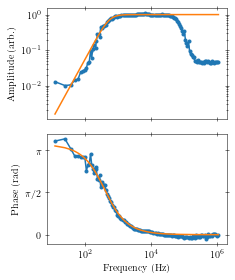

In [19]:
def highpass_amp_func(f, f0, a, b):
    return a / np.sqrt(1 + (f0/f)**(b))
def highpass_phase_func(f, f0, a):
    return a * np.arctan(f0/f)

logbin_Npts = 40

logfreq = logbin_func(freq, Npts=logbin_Npts)
mag, phase = np.abs(H), np.angle(H).real
phase[np.logical_and(phase<0, freq<100)] += 2 * np.pi
logmag = logbin_func(mag, Npts=logbin_Npts)
logphase = logbin_func(phase, Npts=logbin_Npts)

fig, axs = plt.subplots(2,1, figsize=(3.375,4), sharex=True)    


fmin, fmax = 0, 3e4
mask = np.logical_and(logfreq>=fmin, logfreq<=fmax)
popt_mag, pcov = curve_fit(highpass_amp_func, logfreq[mask], logmag[mask], p0=[1e3, 1, 1])
perr = np.sqrt(np.diag(pcov))
print(popt_mag)
print(perr)
print(perr/popt_mag)
axs[0].loglog(logfreq, logmag, marker=".")
axs[0].plot(logfreq, highpass_amp_func(logfreq, *popt_mag))
                         
                         
fmin, fmax = 100, 1e4
mask = np.logical_and(logfreq>=fmin, logfreq<=fmax)                       
popt_phase, pcov = curve_fit(highpass_phase_func, logfreq[mask], logphase[mask], p0=[1e3, 1])
perr = np.sqrt(np.diag(pcov))
print(popt_phase)
print(perr)
print(perr/popt_phase)
axs[1].semilogx(logfreq, logphase, marker=".")
axs[1].plot(logfreq, highpass_phase_func(logfreq, *popt_phase))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Phase (rad)")
axs[0].set_ylabel("Amplitude (arb.)")
rads, rad_labels = radian_labels(denoms=[0,2,1])
axs[1].set_yticks(rads)
axs[1].set_yticklabels(rad_labels);

def ac_response(freq):
    return highpass_amp_func(freq, *popt_mag) *\
           np.exp(1j * highpass_phase_func(freq, *popt_phase))
plt.tight_layout()
plt.savefig("figures/20230501/ac-dc_transfer-function.pdf")
plt.savefig("figures/20230501/ac-dc_transfer-function.png", dpi=800)

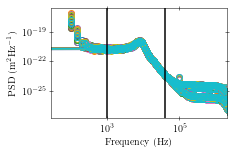

In [20]:
C0s_baseline, monitor_baseline = calibrate_experiment(fnames_baseline, 
                                                      channels={"X": None, 
                                                                "Y":ac_response}, 
                                                      fmin=1e3, 
                                                      fmax=4e4, 
                                                      cutoff=2e6, 
                                                      taumax=20e-3, 
                                                      tmax=None, 
                                                      window="hamming")
plt.tight_layout()
plt.savefig("figures/20230501/ac-dc_baseline_psd-collection.pdf")
plt.savefig("figures/20230501/ac-dc_baseline_psd-collection.png", dpi=800)

k ch 0 : 70.02488449076422 2.6315441980970133 3.758012908174229
k ch 1 : 68.12489846323834 2.314196839057947 3.3969912488115304
rho ch 0 : 1533.4803755462158 29.047967010944305 1.8942509779818737
rho ch 1 : 1525.0279269231273 26.86011467733181 1.76128674125492
cal ch 0 : 1.0787176955437408 0.18645828006050796 17.285178581085702
cal ch 1 : 1.000983755356215 0.11582130671028369 11.57074788582028
chi ch 0 : 511.58010569291616 87.6603050064534 17.13520600800549
chi ch 1 : 136.0883415308695 14.215933683148714 10.44610693556292
T ch 0 : 21.293885176006764 0.09682548517785963 0.45471028127342095
T ch 1 : 21.293885176006764 0.09682548517785963 0.45471028127342095
P ch 0 : 223.62104657987086 1.5225387800753618 0.6808566560981351
P ch 1 : 223.62104657987086 1.5225387800753618 0.6808566560981351


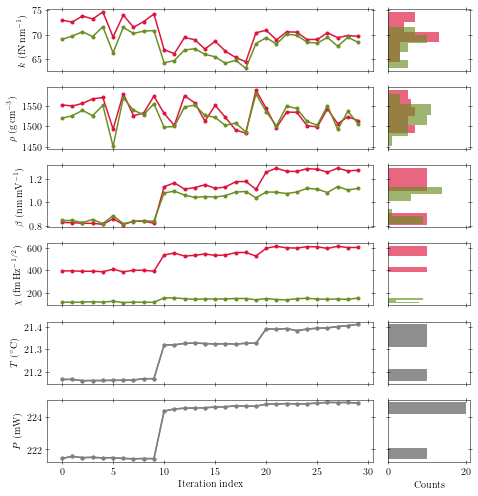

In [31]:
plot_monitor(monitor_baseline)
plt.tight_layout()
plt.savefig("figures/20230501/ac-dc_baseline_monitor.pdf")
plt.savefig("figures/20230501/ac-dc_baseline_monitor.png", dpi=800)

# dc-ac_ene-15-19-5_pos0-10-11

In [22]:
fnames_dc_ac_scan = sort_fnames(find_files(experiment_ders[-6]))

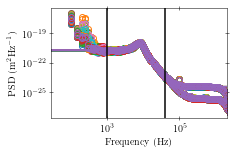

In [23]:
C0s_dc_ac_scan, monitor_dc_ac_scan = calibrate_experiment(fnames_dc_ac_scan, 
                                                      channels={"X": None, 
                                                                "Y":ac_response}, 
                                                      fmin=1e3, 
                                                      fmax=4e4, 
                                                      cutoff=2e6, 
                                                      taumax=20e-3, 
                                                      tmax=81e-3, 
                                                      window="hamming")

enes = []
poss = []
for C in C0s_dc_ac_scan[0]:
    poss.append(C.pos)
    enes.append(C.ene)
poss = np.unique(poss)
enes = np.unique(enes)
plt.tight_layout()
plt.savefig("figures/20230501/ac-dc_ene-pos-scan_psd-collection.pdf")
plt.savefig("figures/20230501/ac-dc_ene-pos-scan_psd-collection.png", dpi=800)

k ch 0 : 68.89262869389808 1.2660019138300591 1.8376449524884957
k ch 1 : 67.80311861635418 1.2681206052486353 1.8702983448651629
rho ch 0 : 1516.7819749665452 27.577802695173173 1.8181784297496968
rho ch 1 : 1520.6352400004662 28.76500531287534 1.8916440022044023
cal ch 0 : 1.2651932386140607 0.02203603644930023 1.741713105694377
cal ch 1 : 1.0916178273793733 0.021385513661112063 1.9590659958762189
chi ch 0 : 599.437151875325 10.275580748430023 1.7142048530497502
chi ch 1 : 142.1356432047775 4.164540421528314 2.9299761323965603
T ch 0 : 21.369094533479288 0.016836869849013683 0.07879074999006205
T ch 1 : 21.369094533479288 0.016836869849013683 0.07879074999006205
P ch 0 : 224.7167251151219 0.21030445603640519 0.09358647244821972
P ch 1 : 224.7167251151219 0.21030445603640519 0.09358647244821972


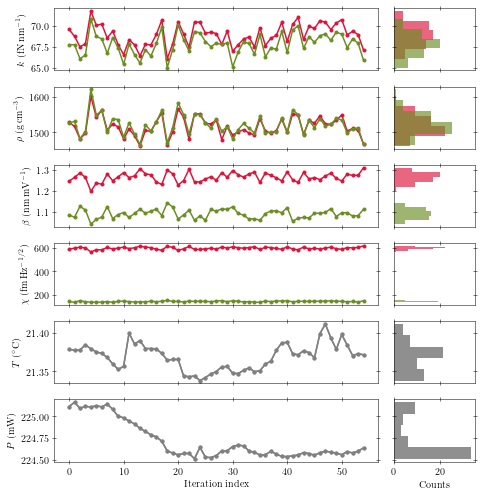

In [32]:
plot_monitor(monitor_dc_ac_scan)
plt.tight_layout()
plt.savefig("figures/20230501/ac-dc_ene-pos-scan_monitor.pdf")
plt.savefig("figures/20230501/ac-dc_ene-pos-scan_monitor.png", dpi=800)

In [25]:
c0s = np.array([get_sound_speed(np.mean(C0.T), RH=C0.RH) for C0 in C0s_dc_ac_scan.ravel()])
c0 = np.mean(c0s)
dc0 = np.std(c0s)
print("c0:", c0, dc0, dc0/c0)

c0: 344.9471917464724 0.010619347005944564 3.078542820475987e-05


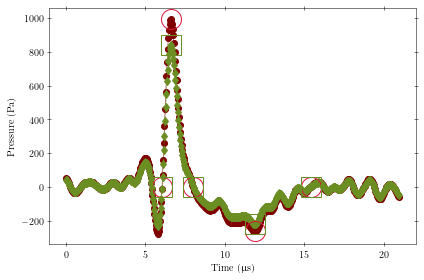

In [48]:
enei = 4
posi = 0
stys= [dict(c="maroon", marker="o", ls="-"),
       dict(c="olivedrab", marker="d", ls="--") ]
relative_shift = 0
dc_cutoff = 8e5
ac_cutoff = 8e5
decimate = False


tmin0 = 0.081284
Dt = 21e-6
fig, ax = plt.subplots(1,1)

pos = poss[posi]
tmin = tmin0 + pos*1e-2/c0

Cdc0 = C0s_dc_ac_scan.reshape(2, len(enes), len(poss))[0, enei, posi]
dc_musphere_response = make_musphere_response(
    Cdc0, response="bassetbound", impedance="plane", r0=0)
Cdc = load_collection(
    Cdc0.fname, "X", dc_musphere_response, 
    tmin=81.2e-3,tmax=82e-3, decimate=decimate,
    differentiate=True, cutoff=dc_cutoff, 
    Npts="cutoff", invert=False)
Cdc.aggrigate(slice(1, 10,1))

Cac0 = C0s_dc_ac_scan.reshape(2, len(enes), len(poss))[1, enei, posi]
musphere_response = make_musphere_response(
    Cac0, response="bassetbound", ac_response=ac_response, impedance="plane", r0=0)
Cac = load_collection(
    Cac0.fname, "X", musphere_response, 
    tmin=81.2e-3,tmax=83e-3, decimate=decimate,
    differentiate=True, cutoff=ac_cutoff, 
    Npts="cutoff", invert=False)
Cac.aggrigate(slice(1, 10,1))

Cdc.agg.plot(ax=ax, tmin=tmin, tmax=tmin+Dt, tshift=-tmin*1e6, lw=0.5, tunit="us", **stys[0])
Cac.agg.plot(ax=ax, tmin=tmin, tmax=tmin+Dt, tshift=-tmin*1e6, lw=0.5, tunit="us", **stys[1])

tpoints, xpoints = find_pulse_points(Cdc.agg, tmin, tmin+Dt, factor=-0.0)
ax.plot((np.array(tpoints)-tmin)*1e6, xpoints, 
        ms=20, marker="o", mec="crimson", ls="none", mfc="none")

tpoints, xpoints = find_pulse_points(Cac.agg, tmin, tmin+Dt, factor=-0.0)
ax.plot((np.array(tpoints)-tmin)*1e6, xpoints, 
        ms=20, marker="s", mec="olivedrab", ls="none", mfc="none")

ax.set_ylabel("Pressure (Pa)")
plt.tight_layout()
plt.savefig("figures/20230501/ac-dc_pulse_example.pdf")
plt.savefig("figures/20230501/ac-dc_pulse_example.png", dpi=800)

In [1184]:
get_sound_speed

<function brownian.get_sound_speed(T, RH=0, p=101325, xCo2=0)>

In [109]:
ac_cutoff = 800e3
dc_cutoff = 800e3
decimate = False
relative_shift = 0
c0 = np.mean(c0)
tmin0 = 0.081283
Dt = 24e-6

Cs_dc_ac_scan =  np.zeros((2, len(enes), len(poss)), dtype="object")

dc_ac_scan_points = np.zeros((2, len(enes), len(poss), 2, 5))

for enei, ene in enumerate(enes):
    print(enei)
    for posi, pos in enumerate(poss):
        pos = poss[posi]
        tmin = tmin0 + pos*1e-2/c0

        Cdc0 = C0s_dc_ac_scan.reshape(2, len(enes), len(poss))[0, enei, posi]
        dc_musphere_response = make_musphere_response(
            Cdc0, response="bassetbound", impedance="plane", r0=0)
        Cdc = load_collection(
            Cdc0.fname, "X", dc_musphere_response, 
            tmin=81.2e-3,tmax=82e-3, decimate=decimate,
            differentiate=True, cutoff=dc_cutoff, 
            Npts="cutoff", invert=False)

        Cac0 = C0s_dc_ac_scan.reshape(2, len(enes), len(poss))[1, enei, posi]
        musphere_response = make_musphere_response(
            Cac0, response="bassetbound", ac_response=ac_response, impedance="plane", r0=0)
        Cac = load_collection(
            Cac0.fname, "X", musphere_response, 
            tmin=81.2e-3,tmax=83e-3, decimate=decimate,
            differentiate=True, cutoff=ac_cutoff, 
            Npts="cutoff", invert=False)
        
        Cdc.aggrigate(slice(1, 10,1))
        Cac.aggrigate(slice(1, 10,1))
        try:
            dc_points = find_pulse_points(Cdc.agg, tmin, tmin+Dt, factor=0.12)
        except ValueError:
            dc_points = (np.array([np.nan]*5), np.array([np.nan]*5))
            print("dc", ene, pos)
        try:
            ac_points = find_pulse_points(Cac.agg, tmin, tmin+Dt, factor=0.12)
        except ValueError:
            ac_points = (np.array([np.nan]*5), np.array([np.nan]*5))
            print("ac", ene, pos)
            
        dc_ac_scan_points[:, enei, posi, :, :] = dc_points, ac_points
        Cs_dc_ac_scan[0, enei, posi] = Cdc
        Cs_dc_ac_scan[1, enei, posi] = Cac

0
1
2
3
4


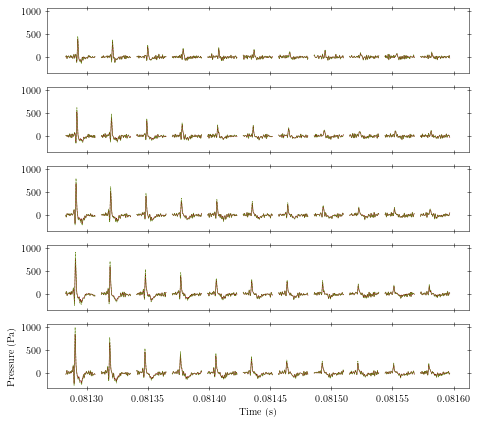

In [110]:
fig, axs = plt.subplots(len(enes), 1, figsize=(2*3.375, 6), sharex=True, sharey=True)
tpeaks, peaks = np.zeros((2, len(enes), len(poss))), np.zeros((2, len(enes), len(poss)))
for enei, ene in enumerate(enes):
    ax = axs[enei]
    for posi, pos in enumerate(poss):
        Cdc, Cac = Cs_dc_ac_scan[:, enei, posi]
        tmin = tmin0 + pos*1e-2/c0
        dc_points = dc_ac_scan_points[0, enei, posi, :, :]
        ac_points = dc_ac_scan_points[1, enei, posi, :, :]
        #ax.plot(*dc_points, marker=".", ls="none")
        #ax.plot(*ac_points, marker=".", ls="none")
        Cac.agg.plot(ax=ax,tmin=tmin, tmax=tmin+Dt, c="maroon", marker="none", lw=0.6, ms=2)
        Cdc.agg.plot(ax=ax,tmin=tmin, tmax=tmin+Dt, c="olivedrab", ls="--", marker="none", lw=0.6, ms=1)
                      
    ax.set_ylabel("")
    ax.set_xlabel("")
ax.set_ylabel("Pressure (Pa)")
ax.set_xlabel(r"Time (s)")
plt.subplots_adjust(hspace=0)
plt.tight_layout()
plt.savefig("figures/20230501/ac-dc_ene-pos-scan.pdf")
plt.savefig("figures/20230501/ac-dc_ene-pos-scan.png", dpi=800)

In [111]:
def fit_powerlaw(x, y, p0, dy=None):
    popt, pcov = curve_fit(powerlaw, x, y, p0=p0, sigma=dy, absolute_sigma=False,
                                     bounds=[(-np.inf, -np.inf), (np.inf, np.inf)])
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

def fit_line(x, y, dy=None):
    speed = np.mean(np.diff(x) / np.diff(y))
    popt, pcov = curve_fit(line, x, y, p0=[speed, x[0]], sigma=dy, absolute_sigma=False)
    perr = np.sqrt(np.diag(pcov))
    return popt, perr


def line(x, speed, x0):
    return (x-x0)/speed


<ipython-input-126-cbb5ab5d43bb>:30: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1,0].get_shared_y_axes().join(axs[1,0], axs[1,1])


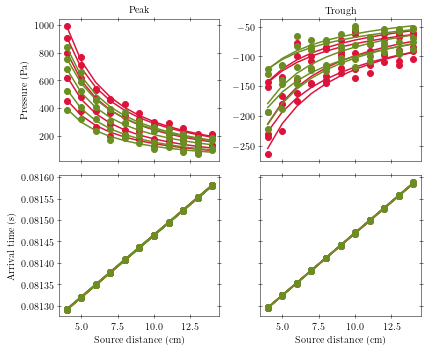

In [126]:
pos0 = 4
abs_poss = pos0 + poss[:]

attenuations  = np.zeros((2, 2, len(enes)))
dattenuations  = np.zeros((2, 2, len(enes)))

speeds  = np.zeros((2, 2, len(enes)))
dspeeds  = np.zeros((2, 2, len(enes)))
fig, axs = plt.subplots(2,2, figsize=(6,5), sharex=True)
for Ci in range(2):
    color =["crimson", "olivedrab"][Ci]
    for enei, en in enumerate(enes):
        for pointi, point_dex in enumerate((1, 3)):
            peak_data = dc_ac_scan_points[Ci, enei, :, 1, point_dex]
            tpeak_data = dc_ac_scan_points[Ci, enei, :, 0, point_dex]
            #mask = 
            popt, perr = fit_powerlaw(abs_poss, np.abs(peak_data), p0=[1,-1])
            attenuations[pointi, Ci, enei] = popt[1]
            dattenuations[pointi, Ci, enei] = perr[1]

            axs[0, pointi].plot(abs_poss, peak_data, marker="o", ls="none", color=color)
            axs[0, pointi].plot(abs_poss, np.sign(peak_data)*powerlaw(abs_poss, *popt), color=color)

            popt, perr = fit_line(abs_poss, tpeak_data)
            speeds[pointi, Ci, enei] = popt[0]*1e-2
            dspeeds[pointi, Ci, enei] = perr[0]*1e-2

            axs[1, pointi].plot(abs_poss, tpeak_data, marker="o", ls="none", color=color)
            axs[1, pointi].plot(abs_poss, line(abs_poss, *popt), color=color)
axs[1,0].get_shared_y_axes().join(axs[1,0], axs[1,1]) 
axs[1,1].set_yticklabels([])
axs[0,0].set_ylabel("Pressure (Pa)")
axs[1,0].set_ylabel("Arrival time (s)")
axs[1,0].set_xlabel("Source distance (cm)")
axs[1,1].set_xlabel("Source distance (cm)")
axs[0,0].set_title("Peak")
axs[0,1].set_title("Trough")
plt.tight_layout()
plt.savefig("figures/20230501/ac-dc_peak-trough-vs-distance.pdf")
plt.savefig("figures/20230501/ac-dc_peak-trough-vs-distance.png", dpi=800)

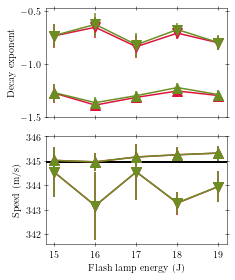

In [127]:
fig, axs = plt.subplots(2,1, figsize=(3.375, 4), sharex=True)
for Ci, color in zip((0, 1), ["crimson", "olivedrab"]):
    axs[0].errorbar(enes, attenuations[0, Ci].T, yerr= dattenuations[0, Ci], marker="^", ms=10, color=color)
    axs[0].errorbar(enes, attenuations[1, Ci].T, yerr=dattenuations[1, Ci], marker="v", ms=10, color=color)
    axs[1].errorbar(enes, speeds[0, Ci], dspeeds[0, Ci], marker="^", ms=10, color=color)
    axs[1].errorbar(enes, speeds[1, Ci], dspeeds[1, Ci], marker="v", ms=10, color=color)
axs[1].axhline(np.mean(c0s), c="k")
axs[1].axhline(np.mean(c0s)+np.std(c0s), c="k")
axs[1].axhline(np.mean(c0s)-np.std(c0s), c="k")
axs[0].set_yticks([-0.5, -1.0, -1.5])
axs[1].set_yticks([346, 345, 344, 343, 342])
axs[0].set_ylabel("Decay exponent")
axs[1].set_ylabel("Speed (m/s)")
axs[1].set_xlabel("Flash lamp energy (J)")
plt.tight_layout()
plt.savefig("figures/20230501/ac-dc_decay-speed-vs-energy.pdf")
plt.savefig("figures/20230501/ac-dc_decay-speed-vs-energy.png", dpi=800)

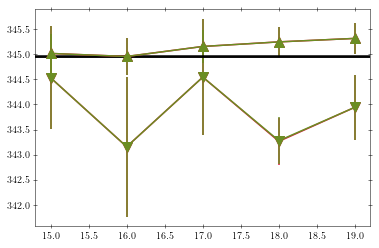

In [115]:
for Ci, color in zip((0, 1), ["crimson", "olivedrab"]):
    plt.errorbar(enes, speeds[0, Ci], dspeeds[0, Ci], marker="^", ms=10, color=color)
    plt.errorbar(enes, speeds[1, Ci], dspeeds[1, Ci], marker="v", ms=10, color=color)
plt.axhline(np.mean(c0s), c="k")
plt.axhline(np.mean(c0s)+np.std(c0s), c="k")
plt.axhline(np.mean(c0s)-np.std(c0s), c="k")

# dc-ph_ene-15-19-5_pos0-10-11

In [1]:
experiment_ders[-3]

NameError: name 'experiment_ders' is not defined

In [ ]:
dc_ac_scan_fnames = sort_fnames(find_files(experiment_ders[-3]))
fmin = 1e3
fmaxs = 4e4
cutoff = 2e6
taumax = 10e-3
tmax = 81e-3
window = "hamming"
ch = "X"

monitor_dc_ph_scan = np.zeros([2, len(dc_ac_scan_fnames), 6])
C0s_dc_ph_scan = np.zeros([2, len(dc_ac_scan_fnames)], dtype="object")
fig, ax = plt.subplots(1,1, figsize=(3.375, 2.25))
for fnamei, fname in enumerate(dc_ac_scan_fnames):
    color = f"C{fnamei}"

    C0 = CollectionTDMS(fname)
    C0.set_collection(ch)
    C0.RH = 55
    C0, ax = psd_calibration(C0, taumax=taumax, tmax=tmax, fmin=fmin, fmax=fmax, 
                             window=window, cutoff=cutoff, plot=True, ax=ax, 
                             color=color, logbin_Npts=40)
    C0s_dc_ph_scan[chi, fnamei] = C0
    monitor_dc_ph_scan[chi, fnamei, :] = [C0.k, C0.rho, C0.cal, np.sqrt(C0.xnoise2), C0.Tavg, np.mean(C0.PDF)+np.mean(C0.PDB)]
    #ax.set_xlim(1e4, 2e5)
    #ax.set_ylim(1e-22, 1e-19)
ax.axvline(fmin, c="k")
ax.axvline(fmax, c="k")
plt.savefig("figures/20230501/dc-ph_ene-pos-scan_psd-collection.pdf")

# No bead

In [1296]:
dc_ac_nb_p2_fnames = sort_fnames(find_files(experiment_ders[0]))
dc_ac_p2_fnames = sort_fnames(find_files(experiment_ders[2]))

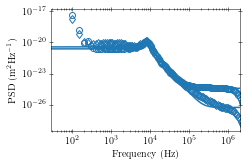

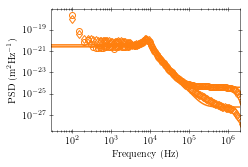

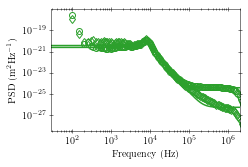

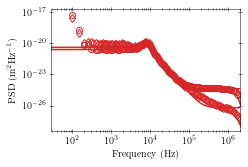

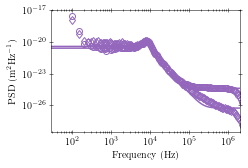

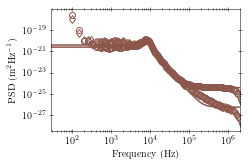

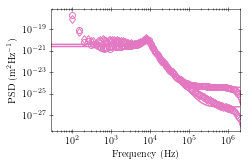

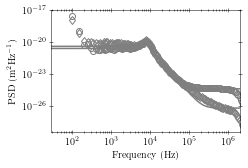

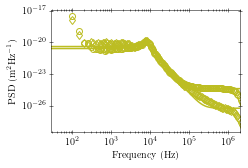

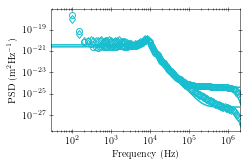

In [1346]:
fmin = 1e3
fmax = 4e4
cutoff = 2e6
taumax = 20e-3
tmax = 81e-3
window = "hamming"

monitor_dc_ac_p2 = np.zeros([2, len(dc_ac_p2_fnames), 6])
C0s_dc_ac_p2 = np.zeros([2, len(dc_ac_p2_fnames)], dtype="object")
#fig, ax = plt.subplots(1,1, figsize=(3.375, 2.25))
for fnamei, fname in enumerate(dc_ac_p2_fnames):
    color = f"C{fnamei}"
    fig, ax = plt.subplots(1,1, figsize=(3.375, 2.25))
    for chi, ch in enumerate(["X", "Y"]):
        C0 = CollectionTDMS(fname)
        C0.set_collection(ch)
        C0.RH = 55
        if ch == "X":
            C0.apply("correct", response=ac_response, window="boxcar", differentiate=False, recollect=True)
            C0.apply("calibrate", cal=-1, inplace=True)
            marker = "d"
        else:
            marker = "o"
        C0, ax = psd_calibration(C0, taumax=taumax, tmax=tmax, fmin=fmin, fmax=fmax, 
                                 window=window, cutoff=cutoff, plot=True, ax=ax, 
                                 color=color, logbin_Npts=40, marker=marker)
        C0s_dc_ac_p2[chi, fnamei] = C0
        monitor_dc_ac_p2[chi, fnamei, :] = [C0.k, C0.rho, C0.cal, np.sqrt(C0.xnoise2), C0.Tavg, np.mean(C0.PDF)+np.mean(C0.PDB)]
    #ax.set_xlim(1e4, 2e5)
    #ax.set_ylim(1e-22, 1e-19)
    plt.show()
ax.axvline(fmin, c="k")
ax.axvline(fmax, c="k")
#plt.savefig("figures/20230501/ac-dc_pulse2_psd-collection.pdf")

k (X) : 48.105386004401836 0.7854145755159776 1.6326957140393987
k (Y) : 59.926658473838266 0.7848078912592091 1.309613970219659
rho (X) : 1140.0902554115053 13.206425421456428 1.1583666607771934
rho (Y) : 1244.534507157136 14.659540722228734 1.1779135602848982
cal (X) : 0.8444740602243691 0.009515156653400612 1.1267553500545087
cal (Y) : 1.3751571440217674 0.015197076006395718 1.1051155915134572
chi (X) : 76.5765023327775 1.4288537596183357 1.8659167186939212
chi (Y) : 636.6891136049169 6.742573625368542 1.0590056404753443
T (X) : 21.708394790297127 0.006483375738644192 0.029865753784531452
T (Y) : 21.708394790297127 0.006483375738644192 0.029865753784531452
P (X) : 225.05745126221126 0.06575946076822964 0.029218966268134895
P (Y) : 225.05745126221126 0.06575946076822964 0.029218966268134895


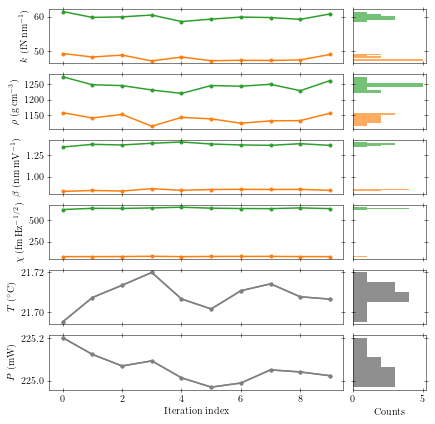

In [1347]:
fig, axs = plt.subplots(6,2, figsize=(2*3.375, 7), 
                        gridspec_kw={"width_ratios":[0.8, 0.2]}, 
                        sharey="row", sharex="col")

ylabels = [r"$k~{\rm (fN \, nm^{-1})}$", r"$\rho~{\rm (g \,cm^{-3})}$", 
           r"$\beta~{\rm (nm \, mV^{-1})}$", r"$\chi~{\rm (fm \, Hz^{-1/2})}$", 
           r"$T~{\rm (^{\circ}C)}$", r"$P~{\rm (mW)}$"]

for parami, param in enumerate(["k", "rho", "cal", "chi", "T", "P"]):
    for chi, ch in enumerate(["X", "Y"]):
        color = f"C{chi+1}"
        vals = monitor_dc_ac_p2[chi, :, parami]
        # units
        if param == "k":
            vals = vals * 1e15 / 1e9
        if param =="cal":
            vals = vals * 1e9 / 1e3
        if param == "chi":
            vals = vals * 1e15
        if param in ("T", "P"):
            color = "gray"

        # plot data
        axs[parami, 0].plot(vals, marker=".", color=color)
        axs[parami, 1].hist(vals, bins=5, orientation="horizontal", color=color, alpha=0.65)
        # labels
        axs[parami, 0].set_ylabel(ylabels[parami])
        axs[-1, 0].set_xlabel("Iteration index")
        axs[-1, 1].set_xlabel("Counts")
        print(param, f"({ch})", ":", np.nanmean(vals), np.nanstd(vals), 100*np.nanstd(vals)/np.nanmean(vals))
plt.subplots_adjust(wspace=0.05)
#plt.savefig("figures/20230501/ac-dc_pulse2_monitor.pdf")

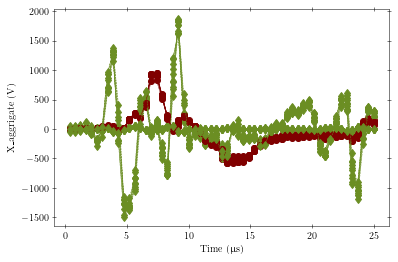

In [1404]:
fig, ax = plt.subplots(1,1)
bead_fname = dc_ac_p2_fnames[5]
nb_fname = dc_ac_nb_p2_fnames[5]
for bead_fname, nb_fname in zip(dc_ac_p2_fnames, dc_ac_nb_p2_fnames):
    stys= [dict(c="maroon", marker="o", ls="-"),
           dict(c="olivedrab", marker="d", ls="--") ]
    relative_shift = 0
    dc_cutoff =1000e3
    ac_cutoff = 1000e3
    decimate = True

    c0 = np.mean(c0)
    tmin0 = 0.081283
    Dt = 25e-6


    C00 = C0s_dc_ac_scan[0, 0]



    tmin = tmin0 + pos*1e-2/c0

    dc_musphere_response = make_musphere_response(
        C00, response="bassetbound", impedance="plane", r0=0)
    Cdc = load_collection(
        bead_fname, "X", dc_musphere_response, 
        tmin=81.2e-3,tmax=82e-3, decimate=decimate,
        differentiate=True, cutoff=dc_cutoff, 
        Npts="cutoff", invert=True)
    Cdc.aggrigate(slice(1, 10,1))

    Cdc_nb = load_collection(
        nb_fname, "X", dc_musphere_response, 
        tmin=81.2e-3,tmax=82e-3, decimate=decimate,
        differentiate=True, cutoff=dc_cutoff, 
        Npts="cutoff", invert=True)
    Cdc_nb.aggrigate(slice(1, 10,1))


    Cdc_nb_raw = load_collection(
        nb_fname, "X", None, 
        tmin=81.2e-3,tmax=82e-3, decimate=decimate,
        differentiate=True, cutoff=dc_cutoff, 
        Npts="cutoff", invert=True)
    Cdc_nb_raw.apply("calibrate", cal=-1/C0.cal/1e6, inplace=True)
    Cdc_nb_raw.aggrigate(slice(1, 10,1))

    Cdc.agg.plot(ax=ax, tmin=tmin, tmax=tmin+Dt, tshift=-tmin*1e6, lw=0.5, tunit="us", **stys[0])
    Cdc_nb.agg.plot(ax=ax, tmin=tmin, tmax=tmin+Dt, tshift=-tmin*1e6, lw=0.5, tunit="us", **stys[1])
    Cdc_nb_raw.agg.plot(ax=ax, tmin=tmin, tmax=tmin+Dt, tshift=-tmin*1e6, lw=0.5, tunit="us", **stys[1])



    #tpoints, xpoints = find_pulse_points(Cdc.agg, tmin, tmin+Dt, factor=-0.0)
    #ax.plot((np.array(tpoints)-tmin)*1e6, xpoints, marker="o")



In [1394]:
1/C0.cal, 200000

(732634.9908012397, 200000)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot: xlabel='Time ($\\rm \\upmu s$)', ylabel='X_aggrigate ($\\rm V$)'>)

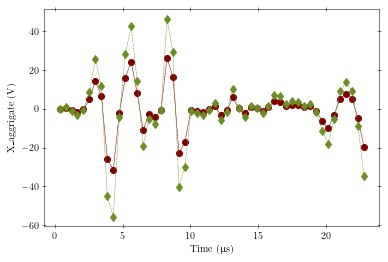

In [1357]:
fname = dc_ac_nb_p2_fnames[0]
stys= [dict(c="maroon", marker="o", ls="-"),
       dict(c="olivedrab", marker="d", ls="--") ]
relative_shift = 0
dc_cutoff =10e5
ac_cutoff = 10e5
decimate = True

c0 = np.mean(c0)
tmin0 = 0.081283
Dt = 23e-6
fig, ax = plt.subplots(1,1)

pos = poss[posi]
tmin = tmin0 + pos*1e-2/c0

Cdc0 = C0s_dc_ac_p2[0, 0]
dc_musphere_response = make_musphere_response(
    Cdc0, response="bassetbound", impedance="plane", r0=0)
Cdc = load_collection(
    fname, "X", dc_musphere_response, 
    tmin=81.2e-3,tmax=82e-3, decimate=decimate,
    differentiate=True, cutoff=dc_cutoff, 
    Npts="cutoff", invert=True)
Cdc.aggrigate(slice(1, 10,1))

Cac0 = C0s_dc_ac_p2[1, 0]
musphere_response = make_musphere_response(
    Cac0, response="bassetbound", ac_response=ac_response, impedance="plane", r0=0)
Cac = load_collection(
    fname, "X", musphere_response, 
    tmin=81.2e-3,tmax=83e-3, decimate=decimate,
    differentiate=True, cutoff=ac_cutoff, 
    Npts="cutoff", invert=True)
Cac.aggrigate(slice(1, 10,1))

Cdc.agg.plot(ax=ax, tmin=tmin, tmax=tmin+Dt, tshift=-tmin*1e6, lw=0.5, tunit="us", **stys[0])
Cac.agg.plot(ax=ax, tmin=tmin, tmax=tmin+Dt, tshift=-tmin*1e6, lw=0.5, tunit="us", **stys[1])

#tpoints, xpoints = find_pulse_points(Cdc.agg, tmin, tmin+Dt, factor=-0.0)
#ax.plot((np.array(tpoints)-tmin)*1e6, xpoints, marker="o")
